# Asteroid clustering

This is a notebook showcasing different ways how asteroids can be clustered together.

The motivation comes from
[another tool I'm working on](https://github.com/MichaelVerdegaal/InfluenceOrbitMapper) for the InfluenceEth game. In
this tool is a neighbours function which is used in a pathfinding algorithm. The problem I had is that the way I
approached it was excruciatingly slow, so I sought a way to precalculate which asteroids are neighbouring which.

The orbit calculation functions come originate the repo above.

## Run this notebook yourself
- Python 3.8+ installed
- Latest .json data export copied to root directory. You can find
  the [direct download link here](https://www.dropbox.com/sh/5g3ww8wi9n0p4s6/AADcR0lgL8iKTQrpiWUC37Oxa?dl=0)
- Install the packages from requirements.txt

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from timeit import default_timer as timer

from functions import load_asteroids

sns.set()
asteroids_df = load_asteroids('asteroids_20210917.json')

In [4]:
coords = np.array(asteroids_df['pos'].values.tolist())
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
print(coords[0])

[-125.31523576  429.7669627    -6.26761286]


[Text(0.5, 1.0, 'Histogram X coordinates'), Text(0, 0.5, 'Frequency')]

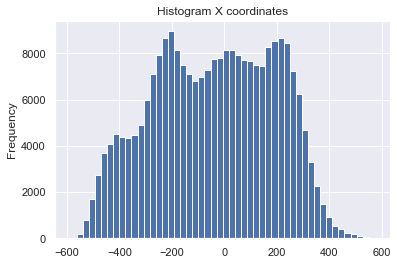

In [3]:
plt.hist(x, bins=50)
plt.gca().set(title='Histogram X coordinates', ylabel='Frequency')

[Text(0.5, 1.0, 'Histogram Y coordinates'), Text(0, 0.5, 'Frequency')]

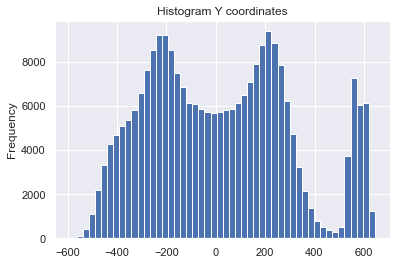

In [4]:
plt.hist(y, bins=50)
plt.gca().set(title='Histogram Y coordinates', ylabel='Frequency')

[Text(0.5, 1.0, 'Histogram Z coordinates'), Text(0, 0.5, 'Frequency')]

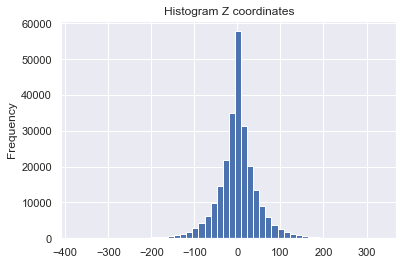

In [5]:
plt.hist(z, bins=50)
plt.gca().set(title='Histogram Z coordinates', ylabel='Frequency')

Text(0.5, 1.0, 'Scatter plot X and Y')

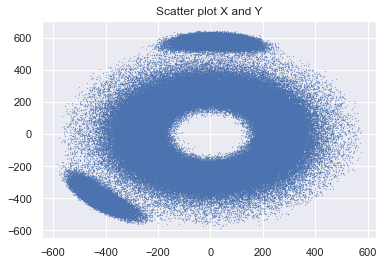

In [6]:
plt.scatter(x, y, s=0.05)
plt.title("Scatter plot X and Y")

## Setting the stage

We have about 250000 total asteroids to work with. Our asteroids are positioned via 3D cartesian coordinates,
consisting of an X, Y and Z, with Z being the height. We'll use the plots above to get some extra information about
them.

### Distribution
We've plotted histograms for each of the coordinate groups. We can see in the X and Y that there are roughly 4 large
groups (which coincides with the next paragraph). Also, visible is that the Z range is a single group and has a lot
smaller range, coming fairly close to a normal distribution.

With this info we can roughly estimate our coordinate plane as [-800/800,-800/800, -400/400]
(bit extra to account for outliers). Combined with the fact that we have this many asteroids, this means that we have
a lot of positions to consider. So extremely slow clustering algorithms may not make the cut.

### Placement

Next, let's look at the scatter plot. We've plotted the X and Y coordinates there, leaving the Z out as it doesn't
matter much for this plot. Clearly visible are 4 separate groups: the inner belt, the outer belt, and 2
trojan clusters. This is a bit harder to see in the main game, but it's similar.

![](https://cdn.discordapp.com/attachments/697855611643232394/904701014987391006/brave_LnODwxWM3X.png)

Although it's nice to have learned this, it doesn't do much good for our clustering practices. So the need here is for
the clustering algorithms to be able to split it up into more than 4 clusters. Something more practical would be
cutting it up like slices (imagine cutting a donut).

Furthermore, some of these asteroids do not comply with these position groups, we name those as the outliers.
As the motivation is a pathfinding algorithm, we don't want to create clusters of say size 1, as this means that
the pathfinding would abrubtly come to a halt in such a case.

## Performance

While an algorithm that clusters perfectly would be nice, we do have to take into consideration speed, an algorithm
that takes half an hour to perform is simply just not suitable. As so we'll set an arbitrary limit of around 1 minute.

### Requirements
Based on the comments above, we will set up the best clustering algorithm as the one that can best adhere to the
conditions below:

- Needs to be able to process a large amount of nodes
- Has to split the asteroids into more than 4 clusters
- Can't create clusters too small (size 1-100)
- Shall calculate the dataset within a minute.

## Clustering algorithms

There are a bunch of choices for clustering algorithms, with the notable ones being K-means and DBSCAN. We'll test out
the ones applicable that are included in the
[Sci-Kit Learn package](https://scikit-learn.org/stable/modules/clustering.html#k-means). But which are applicable?
That would be the inductive clustering algorithms. You have transductive and inductive machine learning models, where
transductive models can not be applied to new and unseen data, and inductive can. As our asteroid positions will
evolve over time we'll need inductive models.

### K-means clustering

K-means clusters by assigning groups into *n* groups of equal variance. This algorithm requires the number of clusters
to be specified.

We'll try out a variation a few amounts of *n* to start off with, 5, 10 and 50.

An *n* of 5 appears to be not useful, as the clusters appear to be too large to properly differentiate between groups.
An *n* of 10 is a lot better as it can actually distinguish between the trojans and the belts, altouggh the groups are
still large. An *n* of 50 does the job properly, so a cluster amount of 50-100 is good. Mathematically, that results in
(n/total asteroids) about 5000 to 2500 asteroids per group.

One caveat though is that the algorithm starts to significantly slow down with a large amount of clusters. With 50
clusters we're already at 3/4 of our hard limit.

This issue can be solved by using MiniBatch K-means, which processes everything in mini-batches (hence the name) of
256, which indeed rapidly speed up the algorithm. The downside is that this comes at a cost of precision, which can
be seen in the graph. Whether this precision loss is worth it is subjective. Personally for this use case i think it's
valid with some tweaking.

In [7]:
start = timer()
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(coords)
y_kmeans = kmeans.predict(coords)
end = timer()
print(f"K-means took {round(end - start, 7)} seconds to process data")

K-means took 3.0623239 seconds to process data


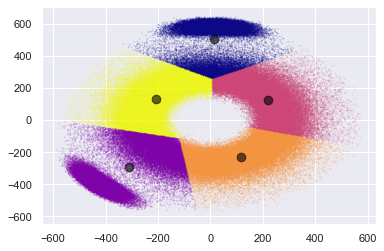

In [8]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_kmeans, s=0.01, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [9]:
start = timer()
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(coords)
y_kmeans = kmeans.predict(coords)
end = timer()
print(f"K-means took {round(end - start, 7)} seconds to process data")

K-means took 5.0845221 seconds to process data


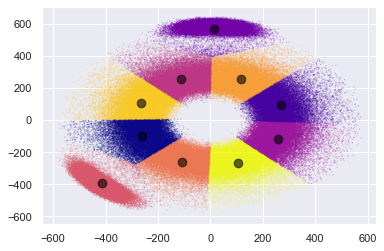

In [10]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_kmeans, s=0.01, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [11]:
start = timer()
kmeans = KMeans(n_clusters=50, random_state=0)
kmeans.fit(coords)
y_kmeans = kmeans.predict(coords)
end = timer()
print(f"K-means took {round(end - start, 7)} seconds to process data")

K-means took 43.2564286 seconds to process data


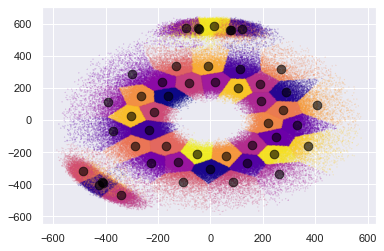

In [12]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_kmeans, s=0.01, cmap='plasma')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [13]:
start = timer()
minikmeans = MiniBatchKMeans(n_clusters=50, random_state=0)
minikmeans.fit(coords)
y_minikmeans = minikmeans.predict(coords)
end = timer()
print(f"K-means took {round(end - start, 7)} seconds to process data")

K-means took 0.7754558 seconds to process data


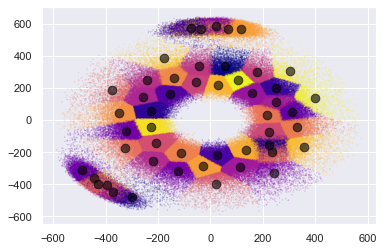

In [14]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_minikmeans, s=0.01, cmap='plasma')
centers = minikmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

### Affinity propagation
Affinity propagation is an algorithm based on the concept of "passing messages" between points. Interesting about it is
that it chooses the amount of clusters on its own. Sadly, this is impossible to run for this dataset, unless you
somehow have 0.5 terabyte of RAM in your pc.....
![](https://cdn.discordapp.com/attachments/697855611643232394/904770800291287120/pycharm64_Vh4z9U7E3O.png)

### Mean-shift
Mean-shift clustering creates blobs with a smooth density for the clusters. This is based on centroids. The algorithm
tries to make the centroids be mean to the points within a region.

One parameter that needs to be provided is the bandwidth, which is the distance of the kernel function, and can be seen
as the factor that defines the cluster count. The bandwidth can be estimated using a function. While this also takes
time to execute, this technically only needs to be done once, so it's not timed.

We see however in the results, that the estimate is not very good, so in the next examples we define our own.
We try out a bandwidth of 50 and 100 based on our coordinate plane range. (do note that these values are not related to
our cluster estimates, despite being the same numbers)

The 100 bandwidth estimation looked a lot better, especially encapsulating the trojans well, still however, the groups
were too large. For the 50 bandwidth estimation we did get a good amount of groups, but they're all over. The centroids
seem to be located mostly towards the outliers, which is not ideal.

In [15]:
bandwidth = estimate_bandwidth(coords, quantile=0.2, n_samples=500)
print(f"Estimated bandwidth is {bandwidth}")

start = timer()
meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(coords)
y_meanshift = meanshift.predict(coords)
end = timer()
print(f"Mean-shift took {round(end - start, 7)} seconds to process data")

Estimated bandwidth is 263.7087602425852
Mean-shift took 39.1919692 seconds to process data


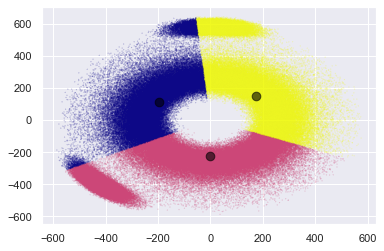

In [16]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_meanshift, s=0.01, cmap='plasma')
centers = meanshift.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [17]:
start = timer()
meanshift = MeanShift(bandwidth=50, bin_seeding=True)
meanshift.fit(coords)
y_meanshift = meanshift.predict(coords)
end = timer()
print(f"Mean-shift took {round(end - start, 7)} seconds to process data")

Mean-shift took 183.1379297 seconds to process data


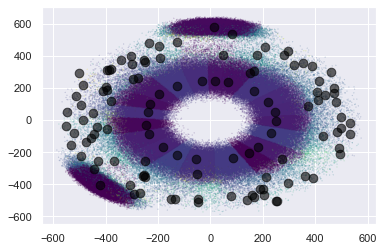

In [18]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_meanshift, s=0.01, cmap='viridis')
centers = meanshift.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [19]:
start = timer()
meanshift = MeanShift(bandwidth=100, bin_seeding=True)
meanshift.fit(coords)
y_meanshift = meanshift.predict(coords)
end = timer()
print(f"Mean-shift took {round(end - start, 7)} seconds to process data")

Mean-shift took 48.9594642 seconds to process data


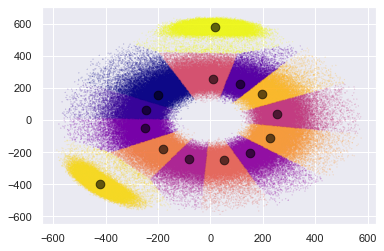

In [20]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_meanshift, s=0.01, cmap='plasma')
centers = meanshift.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

### Gaussian mixture

Gaussian mixture models are algorithms that assumes that all points are generated from a finite amount of gaussian
distributions. We actually have two variants for this category. Interesting about these models is that they can assign
a probability to clusters, instead of each point having a hard limited to 1 cluster. We know though, that our x and y
positions do not have a gaussian distribution at all, so theoretically these models shouldn't perform well.

They have 1 main parameter, the number of components, for which we'll choose 10 and 50.


As for the results, they're actually pretty decent. The 50 components versions split up the clusters fairly well, with
the gaussian mixture doing a little better compared to the bayesian mixture as it spaces out the mean points better. As
for execution time though, bayesian mixture does not make the cut, as it's way too slow.

In [21]:
start = timer()
gaussmix = GaussianMixture(n_components=10)
gaussmix.fit(coords)
y_gaussmix = meanshift.predict(coords)
end = timer()
print(f"Gaussian mixture took {round(end - start, 7)} seconds to process data")

Gaussian mixture took 3.0798221 seconds to process data


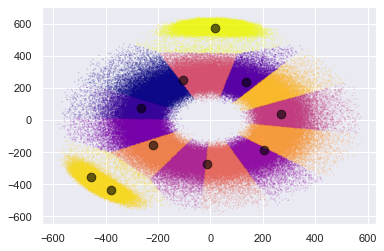

In [22]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_gaussmix, s=0.01, cmap='plasma')
centers = gaussmix.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [23]:
start = timer()
gaussmix = GaussianMixture(n_components=50)
gaussmix.fit(coords)
y_gaussmix = meanshift.predict(coords)
end = timer()
print(f"Gaussian mixture took {round(end - start, 7)} seconds to process data")

Gaussian mixture took 30.1886638 seconds to process data


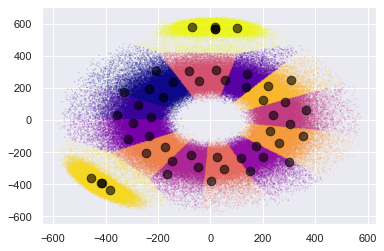

In [24]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_gaussmix, s=0.01, cmap='plasma')
centers = gaussmix.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

### Variational Bayesian Gaussian mixture

Variational inference methods in Bayesian inference and machine learning are techniques which are involved in
approximating intractable integrals. This variant allows this to happen on the gaussian mixture model.

In [25]:
start = timer()
baygaussmix = BayesianGaussianMixture(n_components=10, max_iter=200)
baygaussmix.fit(coords)
y_baygaussmix = meanshift.predict(coords)
end = timer()
print(f"Gaussian mixture took {round(end - start, 7)} seconds to process data")

a:\software\coding projects\asteroidclustering\venv\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Gaussian mixture took 81.0733769 seconds to process data


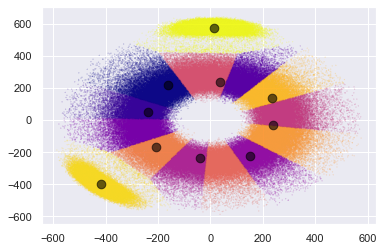

In [26]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_baygaussmix, s=0.01, cmap='plasma')
centers = baygaussmix.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);

In [27]:
start = timer()
baygaussmix = BayesianGaussianMixture(n_components=50, max_iter=200)
baygaussmix.fit(coords)
y_baygaussmix = meanshift.predict(coords)
end = timer()
print(f"Gaussian mixture took {round(end - start, 7)} seconds to process data")

a:\software\coding projects\asteroidclustering\venv\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Gaussian mixture took 393.1837688 seconds to process data


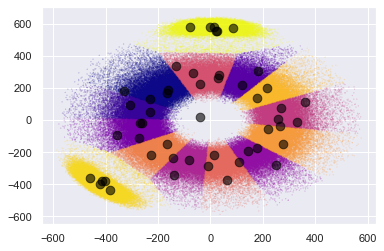

In [28]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_baygaussmix, s=0.01, cmap='plasma')
centers = baygaussmix.means_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.6);


### BIRCH

BIRCH is an algorithm that builds a tree structure to create clusters. This is interesting as that should be very fast,
though it's reported to struggle with high dimensional data. Luckily we only have 3 dimensions, so this is not a
problem.

As for parameters there are 2 big ones, threshold and branching factor, the former controls the distance between a
sample and subclusters, and the latter limits the number of subclusters in a node. VERY BIG CAVEAT THOUGH, be sure to
set the treshold parameter properly. Setting at the default for this problem results in it splitting about 245k times,
which took the algorithm about 20 minutes. The trick is to make sure the threshold is large enough to not have this
happen, but small enough to get a good representation of the data, this will take some experimentation.

As for the results, they look really good, almost like a paint pallette. I like these clusters as the main data doesn't
have clear sections either. Some sections look like they contain tinier clusters, but this is a limitation of the color
representation, as can be seen if we include markers for the centers in the plot below that.

Execution time is decent, some dozen seconds to fit.

In [14]:
start = timer()
birch = Birch(threshold=50,branching_factor=50, n_clusters=None)
birch.fit(coords)
y_baygaussmix = birch.predict(coords)
end = timer()
print(f"BIRCH took {round(end - start, 7)} seconds to process data")

BIRCH took 12.1103523 seconds to process data


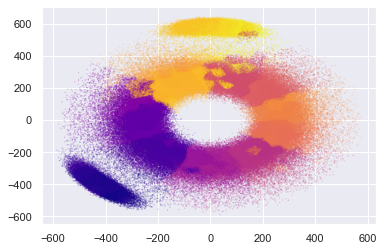

In [19]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_baygaussmix, s=0.01, cmap='plasma')

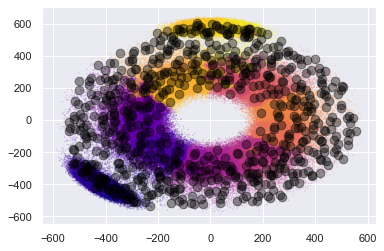

In [20]:
plt.scatter(coords[:, 0], coords[:, 1], c=y_baygaussmix, s=0.01, cmap='plasma')
centers = birch.subcluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=75, alpha=0.4);

## References
https://scikit-learn.org/stable/modules/clustering.html
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95
https://ashkush.medium.com/variational-inference-gaussian-mixture-model-52595074247b
https://morioh.com/p/c23e0d680669